In [1]:
# ssh -L 8000:localhost:8888 ferhs@masterspk
# ~/.local/bin/jupyter-lab ou notebook
# Coletar o token gerado remotamente
# http://localhost:8000/lab?token=d748ed0a1a21f85cb7fea1cf633beb37b0d1b55ffd509620
import platform
print('Python Version ->', platform.python_version())
import findspark
findspark.init('/usr/local/spark2/')
findspark.find()
# findspark.init()
import pyspark
findspark.find()
print('Spark Version ->', pyspark.__version__)

Python Version -> 3.6.9
Spark Version -> 2.4.6


In [16]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf, SparkFiles
from datetime import date
import json
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
appName = "Estudo_Cov_Vac"

# spark = SparkSession \
#         .builder \
#         .appName(appName) \
#         .master('local[*]')\
#         .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.2.1")\
#         .config("spark.mongodb.input.uri", "mongodb://localhost:27017/CovidDB") \
#         .config("spark.mongodb.output.uri", "mongodb://localhost:27017/CovidDB") \
#         .getOrCreate()

spark = SparkSession \
        .builder \
        .appName(appName) \
        .master('spark://192.168.1.10:7077')\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.2.1")\
        .config("spark.mongodb.input.uri", "mongodb://ferhspz:27017/CovidDB") \
        .config("spark.mongodb.output.uri", "mongodb://ferhspz:27017/CovidDB") \
        .getOrCreate()

spark

### Funções Auxiliares

In [3]:
f.udf(returnType=f.StringType())
def returnStr(s):
    return s

def plot(title, x, y, xlabel, ylabel, cor, dlt):
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(25, 8))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, color=cor)
    plt.xticks(rotation=90)
    if dlt == 's':
        plt.xticks([]) 
    plt.show()

### Carregando base de dados consolidados Covid_X_Vacina

In [4]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
                .option("uri", "mongodb://ferhspz:27017/CovidDB.dados_consolidados_vac_casos_covid_sp")\
                .load()
df.printSchema()
df.agg({'Data': 'max'}).show()
# df.createOrReplaceTempView("tabCovVac")
# spark.sql(''' select Data,
#                      Casos_por_Dia,
#                      Obitos_por_Dia,
#                      Total_de_Doses_Apl_Dia, 
#                      Lista_Vac
#               from tabCovVac 
#               where Data in (select max(Data) from tabCovVac)''').show(20,False)
df.select('Data', 'Casos_por_Dia', 'Obitos_por_Dia', 'Total_de_Doses_Apl_Dia', 'Lista_Vac').orderBy(df.Data.desc()).show(20,False)

root
 |-- Casos_por_Dia: integer (nullable = true)
 |-- Data: string (nullable = true)
 |-- Lista_Vac: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Tp_Dose: string (nullable = true)
 |    |    |-- Qtd_Doses_Apl_Dia: integer (nullable = true)
 |-- Obitos_por_Dia: integer (nullable = true)
 |-- Total_de_Doses_Apl_Dia: long (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)

+----------+
| max(Data)|
+----------+
|2022-09-30|
+----------+

+----------+-------------+--------------+----------------------+---------------------------------------------------------------------------------------------------------------------------------+
|Data      |Casos_por_Dia|Obitos_por_Dia|Total_de_Doses_Apl_Dia|Lista_Vac                                                                                                                        |
+----------+-------------+--------------+----------------------+---------------------

### Total de Casos X Mortes X Pessoas Vacinadas

In [5]:
df.select(f.format_number(f.sum('Casos_por_Dia'),0).alias('Total de Casos')\
        , f.format_number(f.sum('Obitos_por_Dia'),0).alias('Total de Mortos')\
        , f.format_number(f.sum('Total_de_Doses_Apl_Dia'),0).alias('Total de Doses Aplicadas')).show()

df.groupBy(f.substring('Data',1,4).alias('Ano')).agg(f.format_number(f.sum('Casos_por_Dia'),0).alias('Total de Casos')\
                                                   , f.format_number(f.sum('Obitos_por_Dia'),0).alias('Total de Mortos')\
                                                   , f.format_number(f.sum('Total_de_Doses_Apl_Dia'),0).alias('Total de Doses Aplicadas')).orderBy('Ano').show()

+--------------+---------------+------------------------+
|Total de Casos|Total de Mortos|Total de Doses Aplicadas|
+--------------+---------------+------------------------+
|     6,096,112|        174,604|             123,758,474|
+--------------+---------------+------------------------+

+----+--------------+---------------+------------------------+
| Ano|Total de Casos|Total de Mortos|Total de Doses Aplicadas|
+----+--------------+---------------+------------------------+
|2020|     1,462,297|         46,717|                       0|
|2021|     2,993,811|        108,488|              84,932,054|
|2022|     1,640,004|         19,399|              38,826,420|
+----+--------------+---------------+------------------------+



### Gráfico de Evolução Casos X Mortes X Pessoas Vacinadaa por Dia

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:251: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


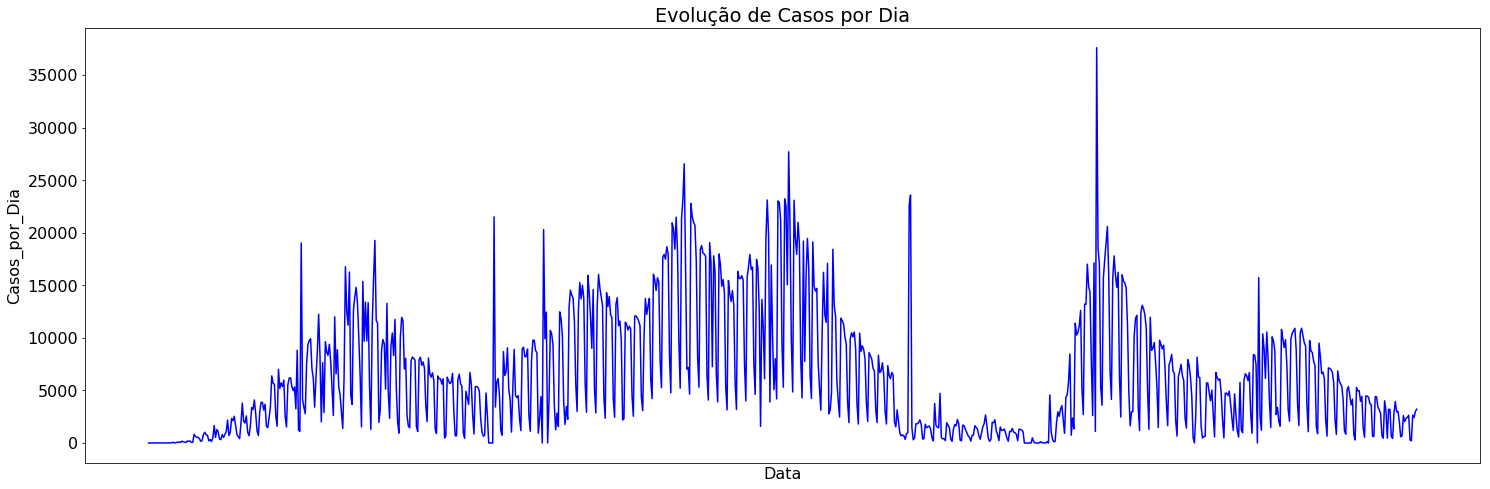

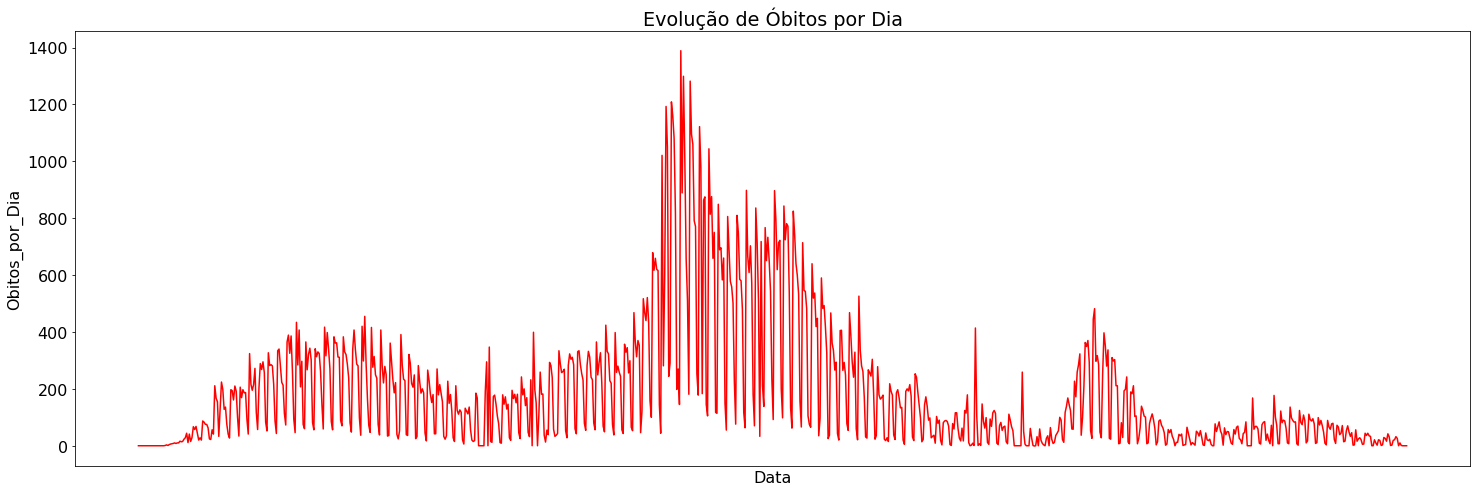

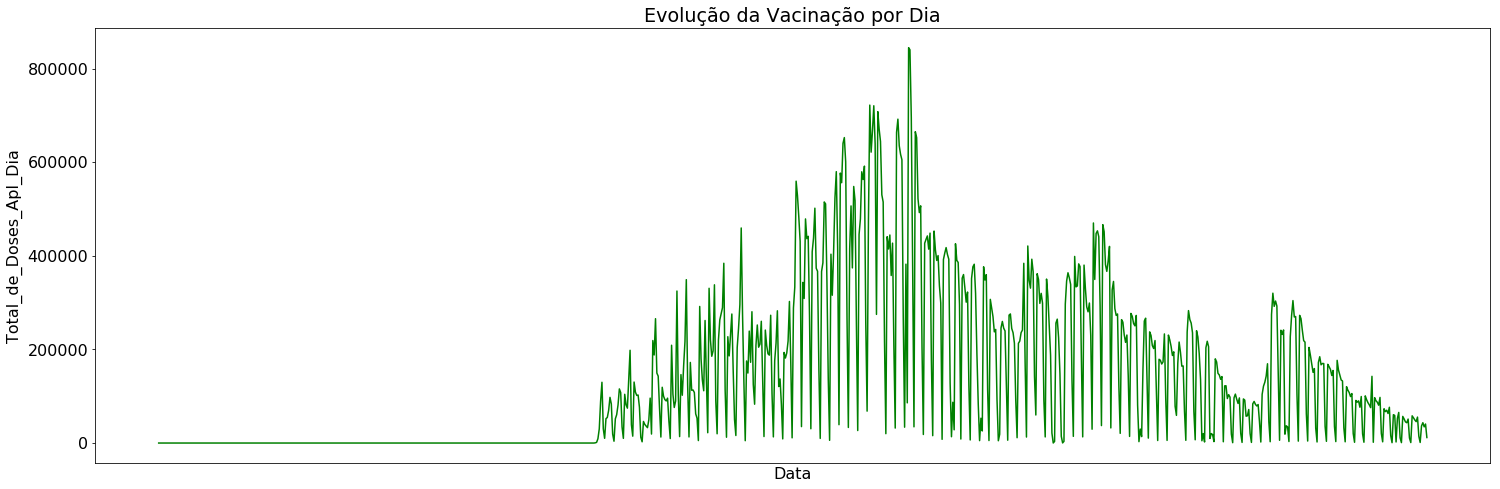

In [6]:
pdf = df.orderBy('Data').toPandas()

plot('Evolução de Casos por Dia', pdf.Data, pdf.Casos_por_Dia, "Data", "Casos_por_Dia", 'b', 's')
plot('Evolução de Óbitos por Dia', pdf.Data, pdf.Obitos_por_Dia, "Data", "Obitos_por_Dia", 'r', 's')
plot('Evolução da Vacinação por Dia', pdf.Data, pdf.Total_de_Doses_Apl_Dia, "Data", "Total_de_Doses_Apl_Dia", 'g', 's')

### Quebrando a base para uma visão mensal

In [7]:
dfm = df.groupBy(f.substring('Data',1,7).alias('anoMes')).agg(f.sum('Casos_por_Dia').alias('Casos_por_Mes')\
                                                            , f.sum('Obitos_por_Dia').alias('Obitos_por_Mes')\
                                                            , f.sum('Total_de_Doses_Apl_Dia').alias('Total_de_Doses_Apl_Mes'))
                                                         
vacAux = df.select('Data', f.explode(df.Lista_Vac).alias('Lista_Vac'))
# vacAux.show(10,False)
# vacAux.printSchema()
vacAux = vacAux.groupBy(f.substring('Data',1,7).alias('anoMes'), vacAux.Lista_Vac['Tp_Dose'].alias('Tp_Dose')).agg(f.sum(vacAux.Lista_Vac['Qtd_Doses_Apl_Dia']).alias('Qtd_Doses_Apl_Mes'))
vacAux.show(10,False)
vacMes = vacAux.groupBy('anoMes').agg(f.collect_list(f.struct('Tp_Dose', 'Qtd_Doses_Apl_Mes')).alias('Lista_Vac'))
vacMes.printSchema()
vacMes.show(10,False)

dfm = dfm.join(vacMes.alias('VacJoin').select(f.col('VacJoin.anoMes').alias('VacJoinDt'), f.col('VacJoin.Lista_Vac'))\
                               , dfm.anoMes == f.col('VacJoinDt'), 'left').drop('VacJoinDt').na.fill(0).na.fill("")
                
dfm.printSchema()
dfm.orderBy(dfm.anoMes.desc()).show(20,False)

+-------+-----------------+-----------------+
|anoMes |Tp_Dose          |Qtd_Doses_Apl_Mes|
+-------+-----------------+-----------------+
|2022-06|2º DOSE ADICIONAL|3447005          |
|2022-08|1º DOSE ADICIONAL|502763           |
|2021-02|ÚNICA            |41               |
|2022-04|2º DOSE ADICIONAL|2363689          |
|2021-03|2º DOSE ADICIONAL|4                |
|2021-11|3º DOSE ADICIONAL|51               |
|2022-09|ÚNICA            |445              |
|2021-02|2º DOSE ADICIONAL|6                |
|2021-07|2º DOSE          |3392116          |
|2021-08|2º DOSE          |7028127          |
+-------+-----------------+-----------------+
only showing top 10 rows

root
 |-- anoMes: string (nullable = true)
 |-- Lista_Vac: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Tp_Dose: string (nullable = true)
 |    |    |-- Qtd_Doses_Apl_Mes: long (nullable = true)

+-------+-----------------------------------------------------------------------------------

### Gráfico de Evolução Casos X Mortes X Pessoas Vacinadaa por Mês

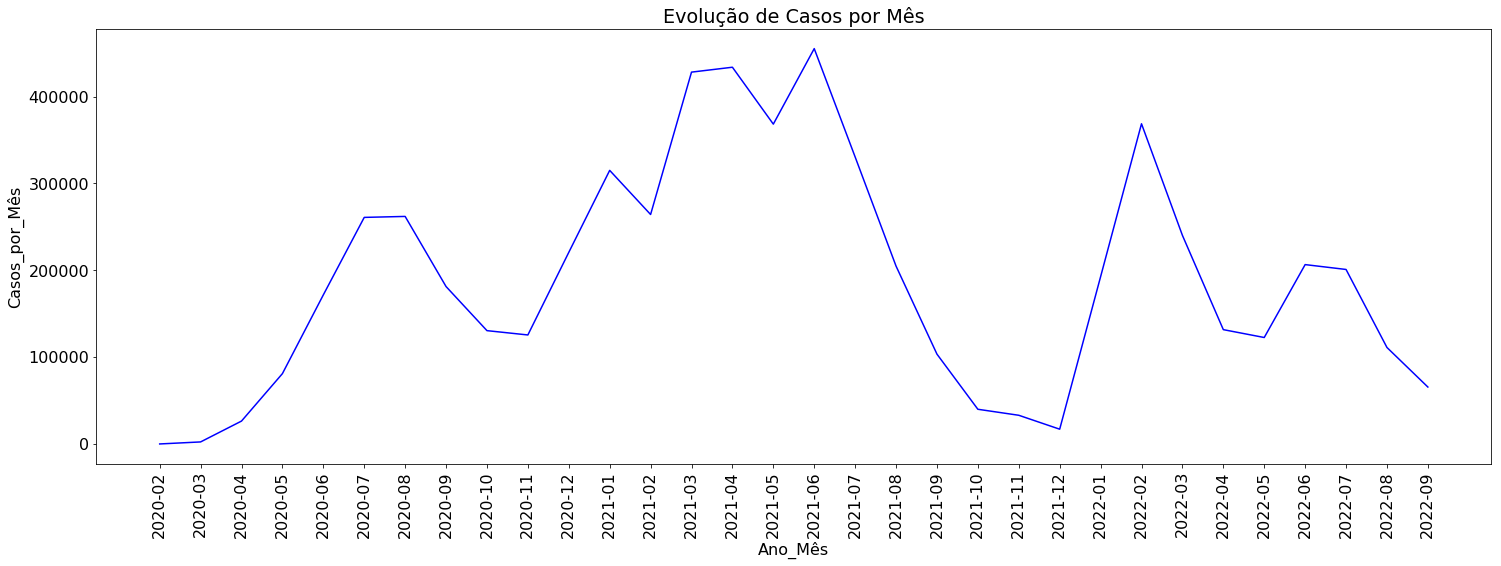

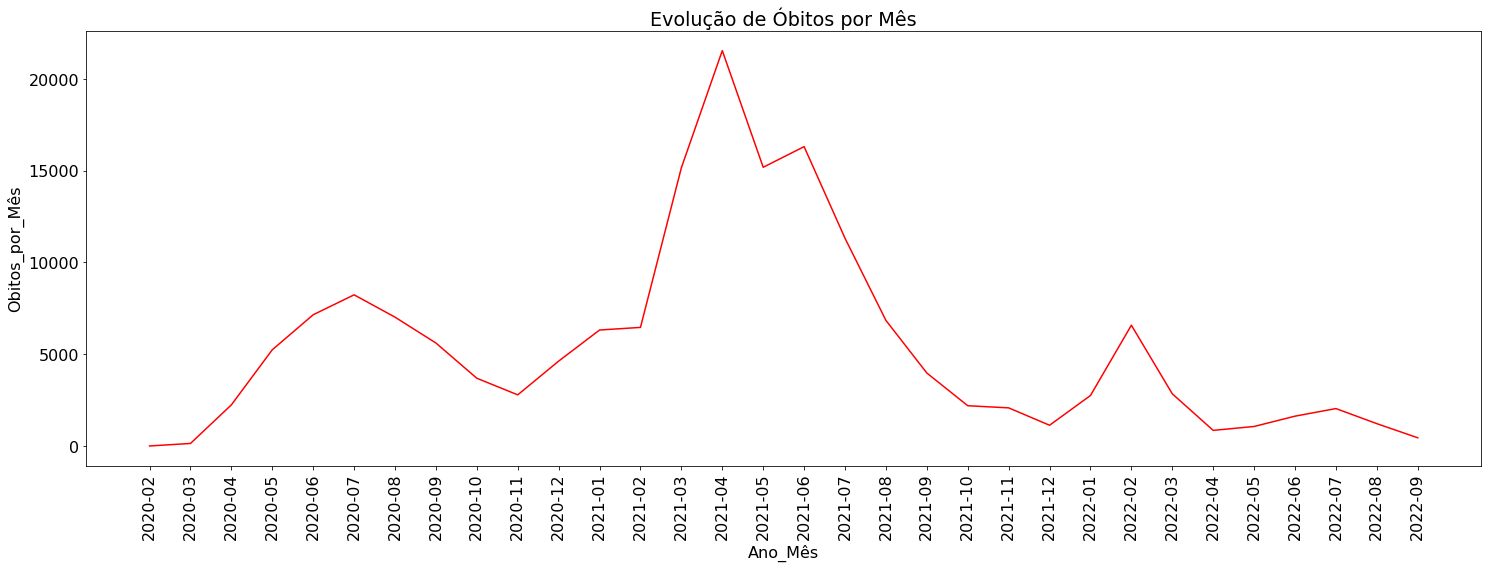

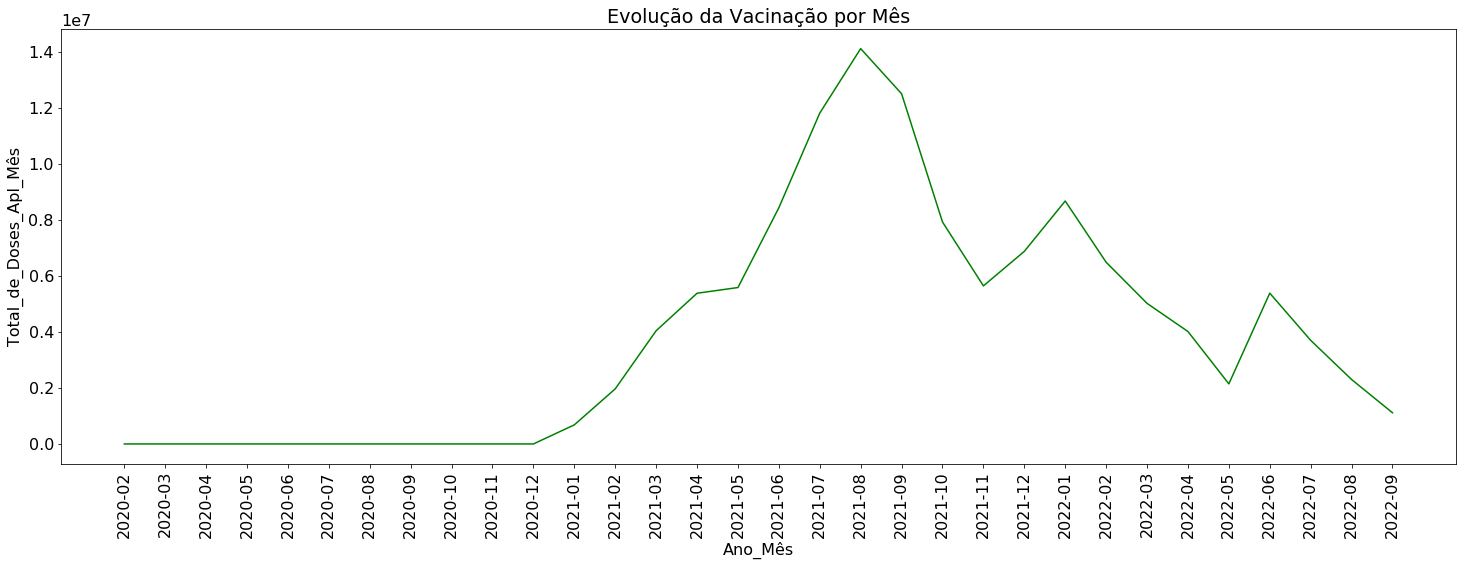

In [8]:
pdf = dfm.orderBy('anoMes').toPandas()

plot('Evolução de Casos por Mês', pdf.anoMes, pdf.Casos_por_Mes, "Ano_Mês", "Casos_por_Mês", 'b', 'n')
plot('Evolução de Óbitos por Mês', pdf.anoMes, pdf.Obitos_por_Mes, "Ano_Mês", "Obitos_por_Mês", 'r', 'n')
plot('Evolução da Vacinação por Mês', pdf.anoMes, pdf.Total_de_Doses_Apl_Mes, "Ano_Mês", "Total_de_Doses_Apl_Mês", 'g', 'n')

### Calculando a Correlação entre Infecção X Mortes, Vacinação X Infecção, Vacinação X Mortes

In [9]:
print('Correlação entre Casos de Infecção e Mortes Causadas pela Covid-19')
print(dfm.stat.corr('Casos_por_Mes', 'Obitos_por_Mes'), '\n')

dfmAux = dfm.where(dfm.anoMes >= '2020-12')
print('Correlação entre Vacinação e Casos de Infecção por Covid-19')
print(dfmAux.stat.corr('Total_de_Doses_Apl_Mes', 'Casos_por_Mes'), '\n')

print('Correlação entre Vacinação e Mortes Causadas pela Covid-19')
print(dfmAux.stat.corr('Total_de_Doses_Apl_Mes', 'Obitos_por_Mes'), '\n')

# ############################################################################################################
from pyspark.sql import Window

dfmAux = dfmAux.withColumn('auxCumSum', f.lit('cov'))
windowval = (Window.partitionBy(dfmAux.auxCumSum).orderBy(dfmAux.anoMes)
                   .rangeBetween(Window.unboundedPreceding, 0))

dfm_m_cumsum = dfmAux.withColumn('cum_sum_vac', f.sum(dfmAux.Total_de_Doses_Apl_Mes).over(windowval))\
                     .withColumn('cum_sum_cas', f.sum(dfmAux.Casos_por_Mes).over(windowval))\
                     .withColumn('cum_sum_obt', f.sum(dfmAux.Obitos_por_Mes).over(windowval))

# dfm_w_cumsum.orderBy(dfm_w_cumsum.anoMes).show(5,False)

print('Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas')
print(dfm_m_cumsum.stat.corr('cum_sum_vac', 'Casos_por_Mes'), '\n')

print('Correlação entre Vacinação e Mortes Causadas pela Covid-19, Acumulado de vacinas Aplicadas')
print(dfm_m_cumsum.stat.corr('cum_sum_vac', 'Obitos_por_Mes'), '\n')

# print('Correlação entre Vacinação e Casos de Infecção por Covid-19, Todos Valores Acumulados')
# print(dfm_m_cumsum.stat.corr('cum_sum_vac', 'cum_sum_cas'), '\n')

# print('Correlação entre Vacinação e Mortes Causadas pela Covid-19, Todos Valores Acumulados')
# print(dfm_m_cumsum.stat.corr('cum_sum_vac', 'cum_sum_obt'), '\n')

###############################################################################################################
vacAux = vacAux.where(vacAux.anoMes >= '2020-12')
windowval = (Window.partitionBy(vacAux.Tp_Dose).orderBy(vacAux.anoMes)
                   .rangeBetween(Window.unboundedPreceding, 0))

dfm_vac_cumsum = vacAux.withColumn('cum_sum_dose', f.sum(vacAux.Qtd_Doses_Apl_Mes).over(windowval))

# dfm_vac_cumsum.orderBy(dfm_vac_cumsum.anoMes).show(20,False)

dfmVac = dfm_m_cumsum.join(dfm_vac_cumsum.alias('VacJoin').select(f.col('VacJoin.anoMes').alias('VacJoinDt')\
                                                                , f.col('VacJoin.Tp_Dose')\
                                                                , f.col('VacJoin.cum_sum_dose'))\
                                                                , dfm_m_cumsum.anoMes == f.col('VacJoinDt'), 'left').drop('VacJoinDt').na.fill(0).na.fill("")

# dfmVac.orderBy(dfmVac.anoMes).show(20,False)

print('Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas 1º DOSE')
dfmVac1 = dfmVac.where(dfmVac.Tp_Dose == '1º DOSE')
print(dfmVac1.stat.corr('cum_sum_dose', 'Casos_por_Mes'), '\n')

print('Correlação entre Vacinação e Mortes de Infecção por Covid-19, Acumulado de vacinas Aplicadas 1º DOSE')
print(dfmVac1.stat.corr('cum_sum_dose', 'Obitos_por_Mes'), '\n')
dfmVac1.unpersist()


print('Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas 2º DOSE')
dfmVac2 = dfmVac.where(dfmVac.Tp_Dose == '2º DOSE')
print(dfmVac2.stat.corr('cum_sum_dose', 'Casos_por_Mes'), '\n')

print('Correlação entre Vacinação e Mortes Causadas pela Covid-19, Acumulado de vacinas Aplicadas 2º DOSE')
print(dfmVac2.stat.corr('cum_sum_dose', 'Obitos_por_Mes'), '\n')
dfmVac2.unpersist()

print('Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas 1º DOSE ADICIONAL')
dfmVac3 = dfmVac.where(dfmVac.Tp_Dose == '1º DOSE ADICIONAL')
print(dfmVac3.stat.corr('cum_sum_dose', 'Casos_por_Mes'), '\n')

print('Correlação entre Vacinação e Mortes Causadas pela Covid-19, Acumulado de vacinas Aplicadas 1º DOSE ADICIONAL')
print(dfmVac3.stat.corr('cum_sum_dose', 'Obitos_por_Mes'), '\n')
dfmVac3.unpersist()

Correlação entre Casos de Infecção e Mortes Causadas pela Covid-19
0.8520564369655019 

Correlação entre Vacinação e Casos de Infecção por Covid-19
0.030473969038143315 

Correlação entre Vacinação e Mortes Causadas pela Covid-19
0.19377877127504686 

Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas
-0.6073228006538866 

Correlação entre Vacinação e Mortes Causadas pela Covid-19, Acumulado de vacinas Aplicadas
-0.7218124372944794 

Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas 1º DOSE
-0.6790641147673084 

Correlação entre Vacinação e Mortes de Infecção por Covid-19, Acumulado de vacinas Aplicadas 1º DOSE
-0.7437102367922561 

Correlação entre Vacinação e Casos de Infecção por Covid-19, Acumulado de vacinas Aplicadas 2º DOSE
-0.7103093693620564 

Correlação entre Vacinação e Mortes Causadas pela Covid-19, Acumulado de vacinas Aplicadas 2º DOSE
-0.812303378145341 

Correlação entre Vacinação e Casos

DataFrame[anoMes: string, Casos_por_Mes: bigint, Obitos_por_Mes: bigint, Total_de_Doses_Apl_Mes: bigint, Lista_Vac: array<struct<Tp_Dose:string,Qtd_Doses_Apl_Mes:bigint>>, auxCumSum: string, cum_sum_vac: bigint, cum_sum_cas: bigint, cum_sum_obt: bigint, Tp_Dose: string, cum_sum_dose: bigint]

In [17]:
dfm_m_cumsum.printSchema()

dfSamp = dfm_m_cumsum.select('anoMes', 'Casos_por_Mes', 'Obitos_por_Mes', 'Total_de_Doses_Apl_Mes', dfm_m_cumsum.Lista_Vac.cast(StringType()), 'auxCumSum', 'cum_sum_vac', 'cum_sum_cas', 'cum_sum_obt')

dfSamp.printSchema()

# dfSamp.write.mode('overwrite').options(header=True, sep=';').csv("/home/ferhs/Documentos/amostraSpark")

root
 |-- anoMes: string (nullable = false)
 |-- Casos_por_Mes: long (nullable = true)
 |-- Obitos_por_Mes: long (nullable = true)
 |-- Total_de_Doses_Apl_Mes: long (nullable = true)
 |-- Lista_Vac: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Tp_Dose: string (nullable = true)
 |    |    |-- Qtd_Doses_Apl_Mes: long (nullable = true)
 |-- auxCumSum: string (nullable = false)
 |-- cum_sum_vac: long (nullable = true)
 |-- cum_sum_cas: long (nullable = true)
 |-- cum_sum_obt: long (nullable = true)

root
 |-- anoMes: string (nullable = false)
 |-- Casos_por_Mes: long (nullable = true)
 |-- Obitos_por_Mes: long (nullable = true)
 |-- Total_de_Doses_Apl_Mes: long (nullable = true)
 |-- Lista_Vac: string (nullable = true)
 |-- auxCumSum: string (nullable = false)
 |-- cum_sum_vac: long (nullable = true)
 |-- cum_sum_cas: long (nullable = true)
 |-- cum_sum_obt: long (nullable = true)

